In [61]:
from pathlib import Path
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from rdkit import Chem
from rdkit.Chem import Descriptors, Draw, PandasTools

In [62]:
HERE = Path(_dh[-1])
DATA = HERE / "data"


In [63]:
import importlib
import logging
import re
from io import StringIO
from xml.dom import minidom
from xml.parsers.expat import ExpatError
from rdkit.Chem import Mol
log = logging.getLogger(__name__)
RDK_MOLS_AS_IMAGE_ATTR = "__rdkitMolAsImage"
InteractiveRenderer = None
PrintAsImageString = None
molJustify = None
pandas_frame = None

In [64]:
pandas_formats = None
for pandas_formats_name in ("pandas.io", "pandas"):
  try:
    pandas_formats = importlib.import_module(f"{pandas_formats_name}.formats")
  except ModuleNotFoundError:
    continue
  break
if pandas_formats is None:
  log.warning("Failed to import pandas formats module")
  raise ModuleNotFoundError
to_html_class = None
for to_html_class_name in ("DataFrameRenderer", "DataFrameFormatter"):
  if hasattr(pandas_formats, "format") and hasattr(pandas_formats.format, to_html_class_name):
    to_html_class = getattr(pandas_formats.format, to_html_class_name)
    if hasattr(to_html_class, "to_html"):
      break
    else:
      to_html_class = None
if to_html_class is None:
  log.warning("Failed to find the pandas to_html method to patch")
  raise AttributeError
dataframeformatter_class = None
orig_get_formatter = None
if (hasattr(pandas_formats.format, "DataFrameFormatter")
    and hasattr(pandas_formats.format.DataFrameFormatter, "_get_formatter")):
  dataframeformatter_class = pandas_formats.format.DataFrameFormatter
  orig_get_formatter = getattr(dataframeformatter_class, "_get_formatter")
if orig_get_formatter is None:
  log.warning("Failed to find the pandas _get_formatter() function to patch")
orig_get_adjustment = None

In [65]:
for get_adjustment_module_name in ("format", "printing"):
  if hasattr(pandas_formats, get_adjustment_module_name):
    get_adjustment_module = getattr(pandas_formats, get_adjustment_module_name)
    for get_adjustment_name in ("get_adjustment", "_get_adjustment"):
      if hasattr(get_adjustment_module, get_adjustment_name):
        orig_get_adjustment = getattr(get_adjustment_module, get_adjustment_name)
        break 
    if orig_get_adjustment is not None:
        break
if orig_get_adjustment is None:
  log.warning("Failed to find the pandas get_adjustment() function to patch")
  raise AttributeError

In [66]:
adj = orig_get_adjustment()
if not hasattr(adj, "len"):
  log.warning(f"Failed to find the pandas {adj.__class.__name__}.len() method to patch")
  raise AttributeError
html_formatter_module = None
html_formatter_class = None
for html_formatter_module_name in ("format", "html"):
  try:
    html_formatter_module = importlib.import_module(
      f"{pandas_formats.__name__}.{html_formatter_module_name}")
  except ModuleNotFoundError:
    continue
  if hasattr(html_formatter_module, "HTMLFormatter"):
    html_formatter_class = getattr(html_formatter_module, "HTMLFormatter")
    break

In [67]:
if html_formatter_class is None:
  log.warning("Failed to find the pandas HTMLFormatter class to patch")
  raise AttributeError
orig_write_cell = None
if not hasattr(html_formatter_class, "_write_cell"):
  log.warning("Failed to find the HTMLFormatter._write_cell() method to patch")
  raise AttributeError
orig_write_cell = getattr(html_formatter_class, "_write_cell")
if not (hasattr(pandas_formats, "printing") and hasattr(pandas_formats.printing, "pprint_thing")):
  log.warning("Failed to find the pprint_thing function")
  raise AttributeError
try:
  import pandas as pd
except ImportError:
  log.warning("Failed to import pandas")
  raise

In [68]:
orig_to_html = getattr(to_html_class, "to_html")
pprint_thing = pandas_formats.printing.pprint_thing
def is_molecule_image(s):
  result = False
  try:
    # is text valid XML / HTML?
    xml = minidom.parseString(s)
    root_node = xml.firstChild
    # check data-content attribute
    if (root_node.nodeName in ['svg', 'img', 'div']
        and 'data-content' in root_node.attributes.keys()
        and root_node.attributes['data-content'].value == 'rdkit/molecule'):
      result = True
  except ExpatError:
    pass  # parsing xml failed and text is not a molecule image
  return result

In [69]:
styleRegex = re.compile("^(.*style=[\"'][^\"^']*)([\"'].*)$")
class MolFormatter:
  """Format molecules as images"""
  def __init__(self, orig_formatter=None):
    """Store original formatters (if any)"""
    self.orig_formatter = orig_formatter
  @staticmethod
  def default_formatter(x):
    """Default formatter function"""
    return pprint_thing(x, escape_chars=("\t", "\r", "\n"))
  @staticmethod
  def is_mol(x):
    """Return True if x is a Chem.Mol"""
    return isinstance(x, Mol)


In [70]:
  @classmethod
  def get_formatters(cls, df, orig_formatters):
    """Return an instance of MolFormatter for each column that contains Chem.Mol objects"""
    df_subset = df.select_dtypes("object")
    return {
      col: cls(orig_formatters.get(col, None))
      for col in df_subset.columns[df_subset.applymap(MolFormatter.is_mol).any()]
    }
  def __call__(self, x):
    """Return x formatted based on its type"""
    if self.is_mol(x):
      return PrintAsImageString(x)
    if callable(self.orig_formatter):
      return self.orig_formatter(x)
    return self.default_formatter(x)

In [71]:
def check_rdk_attr(frame, attr):
  return hasattr(frame, attr) and getattr(frame, attr)
def set_rdk_attr(frame, attr):
  setattr(frame, attr, True)
def patched_to_html(self, *args, **kwargs):
  """A patched version of the to_html method
     that allows rendering molecule images in data frames.
  """
  frame = None
  if self.__class__.__name__ == "DataFrameRenderer":
    fmt = self.fmt
  elif self.__class__.__name__ == "DataFrameFormatter":
    fmt = self
  else:
    raise ValueError(f"patched_to_html: unexpected class {self.__class__.__name__}")
  frame = fmt.frame
  if not check_rdk_attr(frame, RDK_MOLS_AS_IMAGE_ATTR):
    return orig_to_html(self, *args, **kwargs)
  orig_formatters = fmt.formatters
  try:
    formatters = orig_formatters or {}
    if not isinstance(formatters, dict):
      formatters = {col: formatters[i] for i, col in enumerate(self.columns)}
    else:
      formatters = dict(formatters)
    formatters.update(MolFormatter.get_formatters(frame, formatters))
    fmt.formatters = formatters
    res = orig_to_html(self, *args, **kwargs)
    # in pandas 0.25 DataFrameFormatter.to_html() returns None
    if (res is None and not hasattr(html_formatter_class, "get_result") and hasattr(self, "buf")
        and hasattr(self.buf, "getvalue")):
      res = self.buf.getvalue()
    should_inject = res and InteractiveRenderer and InteractiveRenderer.isEnabled()
    if should_inject:
      res = InteractiveRenderer.injectHTMLFooterAfterTable(res)
      # in pandas 0.25 we need to make sure to update buf as return value will be ignored
      if hasattr(self, "buf") and isinstance(self.buf, StringIO):
        self.buf.seek(0)
        self.buf.write(res)
    return res
  finally:
    fmt.formatters = orig_formatters

In [72]:
def patched_get_formatter(self, i, *args, **kwargs):
  if (isinstance(self.formatters, dict) and isinstance(i, int)
      and i not in self.columns and hasattr(self, "tr_col_num")
      and i >= self.tr_col_num):
      max_cols = 0
      if hasattr(self, "max_cols_fitted"):
        max_cols = self.max_cols_fitted
      elif hasattr(self, "max_cols_adj"):
        max_cols = self.max_cols_adj
      n_trunc_cols = len(self.columns) - max_cols
      if n_trunc_cols > 0:
        i += n_trunc_cols
  return orig_get_formatter(self, i, *args, **kwargs)
def patched_write_cell(self, s, *args, **kwargs):
  """ Disable escaping of HTML in order to render img / svg tags """
  styleTags = f"text-align: {molJustify};"
  def_escape = self.escape
  try:
    if hasattr(self.frame, RDK_MOLS_AS_IMAGE_ATTR) and is_molecule_image(s):
      self.escape = False
      kind = kwargs.get('kind', None)
      if kind == 'td':
        tags = kwargs.get('tags', None) or ''
        match = styleRegex.match(tags)
        if match:
          tags = styleRegex.sub(f'\\1 {styleTags}\\2', tags)
        else:
          if tags:
            tags += ' '
          tags += f'style="{styleTags}"'
        kwargs['tags'] = tags
    return orig_write_cell(self, s, *args, **kwargs)
  finally:
    self.escape = def_escape
def patched_get_adjustment():
  """ Avoid truncation of data frame values that contain HTML content """
  adj = orig_get_adjustment()
  orig_len = adj.len
  adj.len = lambda text, *args, **kwargs: (0 if is_molecule_image(text) else orig_len(
    text, *args, **kwargs))
  return adj

In [73]:
def renderImagesInAllDataFrames(images=True):
  if images:
    set_rdk_attr(pd.core.frame.DataFrame, RDK_MOLS_AS_IMAGE_ATTR)
  elif hasattr(pd.core.frame.DataFrame, RDK_MOLS_AS_IMAGE_ATTR):
    delattr(pd.core.frame.DataFrame, RDK_MOLS_AS_IMAGE_ATTR)
def changeMoleculeRendering(frame, renderer='image'):
  if not renderer.lower().startswith('str'):
    set_rdk_attr(frame, RDK_MOLS_AS_IMAGE_ATTR)
  elif hasattr(frame, RDK_MOLS_AS_IMAGE_ATTR):
    delattr(frame, RDK_MOLS_AS_IMAGE_ATTR)
def patchPandas():
  if getattr(to_html_class, "to_html") != patched_to_html:
    setattr(to_html_class, "to_html", patched_to_html)
  if getattr(html_formatter_class, "_write_cell") != patched_write_cell:
    setattr(html_formatter_class, "_write_cell", patched_write_cell)
  if getattr(pandas_formats.format, get_adjustment_name) != patched_get_adjustment:
    setattr(pandas_formats.format, get_adjustment_name, patched_get_adjustment)
  if (orig_get_formatter and getattr(dataframeformatter_class, "_get_formatter") != patched_get_formatter):
    setattr(dataframeformatter_class, "_get_formatter", patched_get_formatter)
def unpatchPandas():
  if orig_to_html:
    setattr(to_html_class, "to_html", orig_to_html)
  if orig_write_cell:
    setattr(html_formatter_class, "_write_cell", orig_write_cell)
  if orig_get_adjustment:
    setattr(pandas_formats.format, get_adjustment_name, orig_get_adjustment)
  if orig_get_formatter:
    setattr(dataframeformatter_class, "_get_formatter", orig_get_formatter)

In [94]:
molecules = pd.read_csv(
    HERE / "Downloads/ADMET.csv",
    index_col=0,
)
print("Shape of dataframe : ", molecules.shape)
molecules.head()

Shape of dataframe :  (46, 2)


SMILES  IC50
ID                                                         
5 ax          C1=CC=CC=C1C2=CC=C(C=C2)C(C)[N]3C=CN=C3  0.17
5 ay       C1=CC(=CC=C1C2=CC=C(C=C2)C(C)[N]3C=CN=C3)F  0.24
5 az      C1=CC(=CC=C1C2=CC=C(C=C2)C(C)[N]3C=CN=C3)OC   1.8
5bx        C1=CC=CC=C1C2=CC3=C(C=C2)C(CC3)[N]4C=CN=C4  0.25
5by   C1=CC(=CC=C1C2=CC3=C(C=C2)C(CC3)[N]4C=CN=C4)[F]  1.11

In [106]:
molecules

SMILES   IC50  \
ID                                                               
5 ax            C1=CC=CC=C1C2=CC=C(C=C2)C(C)[N]3C=CN=C3   0.17   
5 ay         C1=CC(=CC=C1C2=CC=C(C=C2)C(C)[N]3C=CN=C3)F   0.24   
5 az        C1=CC(=CC=C1C2=CC=C(C=C2)C(C)[N]3C=CN=C3)OC    1.8   
5bx          C1=CC=CC=C1C2=CC3=C(C=C2)C(CC3)[N]4C=CN=C4   0.25   
5by     C1=CC(=CC=C1C2=CC3=C(C=C2)C(CC3)[N]4C=CN=C4)[F]   1.11   
5bz      C1=CC(=CC=C1C2=CC3=C(C=C2)C(CC3)[N]4C=CN=C4)OC    2.1   
6ax             C1=CC=CC=C1C2=CC=C(C=C2)C(C)[N]3C=NC=N3     ND   
6ay          C1=CC(=CC=C1C2=CC=C(C=C2)C(C)[N]3C=NC=N3)F     ND   
6az         C1=CC(=CC=C1C2=CC=C(C=C2)C(C)[N]3C=NC=N3)OC     ND   
6bx          C1=CC=CC=C1C2=CC3=C(C=C2)C(CC3)[N]4C=NC=N4     ND   
6by       C1=CC(=CC=C1C2=CC3=C(C=C2)C(CC3)[N]4C=NC=N4)F     ND   
6bz      C1=CC(=CC=C1C2=CC3=C(C=C2)C(CC3)[N]4C=NC=N4)OC     ND   
7ax             C1=CC=CC=C1C2=CC=C(C=C2)C(C)[N]3C=NN=C3     ND   
7ay          C1=CC(=CC=C1C2=CC=C(C=C2)C(C)[N]3C=NN=C3)F     ND   
7az         C1=CC(=CC=C1C2=CC=C(C=C2)C(C)[N]3C=NN=C3)OC     ND   
7bx          C1=CC=CC=C1C2=CC3=C(C=C2)C(CC3)[N]4C=NN=C4     ND   
7by       C1=CC(=CC=C1C2=CC3=C(C=C2)C(CC3)[N]4C=NN=C4)F     ND   
7bz      C1=CC(=CC=C1C2=CC3=C(C=C2)C(CC3)[N]4C=NN=C4)OC     ND   
8                  C1=CC=CC=C1C2=CC=C(C=C2)C[N]3C=NC=C3   0.98   
8a             C1=CC(=CC=C1C2=CC=C(C=C2)C[N]3C=NC=C3)OC    3.7   
8b           C1=CC(=CC=C1C2=CC=C(C=C2)C[N]3C=NC=C3)O[H]   0.31   
8c              C1=CC(=CC=C1C2=CC=C(C=C2)C[N]3C=NC=C3)F   0.96   
8d             C1=CC(=CC=C1C2=CC=C(C=C2)C[N]3C=NC=C3)Cl    5.8   
8e              C1=CC(=CC=C1C2=CC=C(C=C2)C[N]3C=NC=C3)C    4.2   
8f            C1=CC(=CC=C1C2=CC=C(C=C2)C[N]3C=NC=C3)C#N    2.5   
8g      C1=CC(=CC=C1C2=CC=C(C=C2)C[N]3C=NC=C3)C(O[H])=O     ND   
8h             C1=CC(=CC=C1C2=CC=C(C=C2)C[N]3C=NC=C3)SC    7.7   
9a             C1=C(C=CC=C1C2=CC=C(C=C2)C[N]3C=NC=C3)OC   0.59   
9b           C1=C(C=CC=C1C2=CC=C(C=C2)C[N]3C=NC=C3)O[H]   0.13   
9c              C1=C(C=CC=C1C2=CC=C(C=C2)C[N]3C=NC=C3)F   0.66   
9d             C1=C(C=CC=C1C2=CC=C(C=C2)C[N]3C=NC=C3)Cl    1.3   
9e              C1=C(C=CC=C1C2=CC=C(C=C2)C[N]3C=NC=C3)C    1.3   
9i      C1=C(C=CC=C1C2=CC=C(C=C2)C[N]3C=NC=C3)[N](=O)=O    1.8   
9k    C1=C(C=CC=C1C2=CC=C(C=C2)C[N]3C=NC=C3)N(C(C)=O...   0.23   
9l      C1=C(C=CC=C1C2=CC=C(C=C2)C[N]3C=NC=C3)N([H])[H]   0.21   
10a       C1=C4C(=CC=C1C2=CC=C(C=C2)C[N]3C=NC=C3)OCOCO4    3.1   
10b    C1=C(C(=CC=C1C2=CC=C(C=C2)C[N]3C=NC=C3)O[H])O[H]  0.087   
11                 C1=CC=CC=C1C2=CC(=CC=C2)C[N]3C=NC=C3    2.2   
11a            C1=CC(=CC=C1C2=CC(=CC=C2)C[N]3C=NC=C3)OC    4.5   
11b          C1=CC(=CC=C1C2=CC(=CC=C2)C[N]3C=NC=C3)O[H]   0.86   
11c             C1=CC(=CC=C1C2=CC(=CC=C2)C[N]3C=NC=C3)F    2.9   
11d          C1=CC(=CC=C1C2=CC(=CC=C2)C[N]3C=NC=C3)[Cl]     13   
12a            C1=C(C=CC=C1C2=CC(=CC=C2)C[N]3C=NC=C3)OC    3.7   
12b          C1=C(C=CC=C1C2=CC(=CC=C2)C[N]3C=NC=C3)O[H]    1.2   
12k   C1=C(C=CC=C1C2=CC(=CC=C2)C[N]3C=NC=C3)N([H])C(...    2.1   
12l     C1=C(C=CC=C1C2=CC(=CC=C2)C[N]3C=NC=C3)N([H])[H]    4.2   

                                                  ROMol  molecular_weight  \
ID                                                                          
5 ax  <rdkit.Chem.rdchem.Mol object at 0x000001E094C...        248.131349   
5 ay  <rdkit.Chem.rdchem.Mol object at 0x000001E0966...        266.121927   
5 az  <rdkit.Chem.rdchem.Mol object at 0x000001E0966...        278.141913   
5bx   <rdkit.Chem.rdchem.Mol object at 0x000001E0966...        260.131349   
5by   <rdkit.Chem.rdchem.Mol object at 0x000001E0966...        278.121927   
5bz   <rdkit.Chem.rdchem.Mol object at 0x000001E0966...        290.141913   
6ax   <rdkit.Chem.rdchem.Mol object at 0x000001E0966...        249.126597   
6ay   <rdkit.Chem.rdchem.Mol object at 0x000001E0966...        267.117176   
6az   <rdkit.Chem.rdchem.Mol object at 0x000001E0966...        279.137162   
6bx   <rdkit.Chem.rdchem.Mol obje

In [96]:
PandasTools.AddMoleculeColumnToFrame(molecules, "SMILES")
molecules

Failed to patch pandas - unable to change molecule rendering


SMILES   IC50  \
ID                                                               
5 ax            C1=CC=CC=C1C2=CC=C(C=C2)C(C)[N]3C=CN=C3   0.17   
5 ay         C1=CC(=CC=C1C2=CC=C(C=C2)C(C)[N]3C=CN=C3)F   0.24   
5 az        C1=CC(=CC=C1C2=CC=C(C=C2)C(C)[N]3C=CN=C3)OC    1.8   
5bx          C1=CC=CC=C1C2=CC3=C(C=C2)C(CC3)[N]4C=CN=C4   0.25   
5by     C1=CC(=CC=C1C2=CC3=C(C=C2)C(CC3)[N]4C=CN=C4)[F]   1.11   
5bz      C1=CC(=CC=C1C2=CC3=C(C=C2)C(CC3)[N]4C=CN=C4)OC    2.1   
6ax             C1=CC=CC=C1C2=CC=C(C=C2)C(C)[N]3C=NC=N3     ND   
6ay          C1=CC(=CC=C1C2=CC=C(C=C2)C(C)[N]3C=NC=N3)F     ND   
6az         C1=CC(=CC=C1C2=CC=C(C=C2)C(C)[N]3C=NC=N3)OC     ND   
6bx          C1=CC=CC=C1C2=CC3=C(C=C2)C(CC3)[N]4C=NC=N4     ND   
6by       C1=CC(=CC=C1C2=CC3=C(C=C2)C(CC3)[N]4C=NC=N4)F     ND   
6bz      C1=CC(=CC=C1C2=CC3=C(C=C2)C(CC3)[N]4C=NC=N4)OC     ND   
7ax             C1=CC=CC=C1C2=CC=C(C=C2)C(C)[N]3C=NN=C3     ND   
7ay          C1=CC(=CC=C1C2=CC=C(C=C2)C(C)[N]3C=NN=C3)F     ND   
7az         C1=CC(=CC=C1C2=CC=C(C=C2)C(C)[N]3C=NN=C3)OC     ND   
7bx          C1=CC=CC=C1C2=CC3=C(C=C2)C(CC3)[N]4C=NN=C4     ND   
7by       C1=CC(=CC=C1C2=CC3=C(C=C2)C(CC3)[N]4C=NN=C4)F     ND   
7bz      C1=CC(=CC=C1C2=CC3=C(C=C2)C(CC3)[N]4C=NN=C4)OC     ND   
8                  C1=CC=CC=C1C2=CC=C(C=C2)C[N]3C=NC=C3   0.98   
8a             C1=CC(=CC=C1C2=CC=C(C=C2)C[N]3C=NC=C3)OC    3.7   
8b           C1=CC(=CC=C1C2=CC=C(C=C2)C[N]3C=NC=C3)O[H]   0.31   
8c              C1=CC(=CC=C1C2=CC=C(C=C2)C[N]3C=NC=C3)F   0.96   
8d             C1=CC(=CC=C1C2=CC=C(C=C2)C[N]3C=NC=C3)Cl    5.8   
8e              C1=CC(=CC=C1C2=CC=C(C=C2)C[N]3C=NC=C3)C    4.2   
8f            C1=CC(=CC=C1C2=CC=C(C=C2)C[N]3C=NC=C3)C#N    2.5   
8g      C1=CC(=CC=C1C2=CC=C(C=C2)C[N]3C=NC=C3)C(O[H])=O     ND   
8h             C1=CC(=CC=C1C2=CC=C(C=C2)C[N]3C=NC=C3)SC    7.7   
9a             C1=C(C=CC=C1C2=CC=C(C=C2)C[N]3C=NC=C3)OC   0.59   
9b           C1=C(C=CC=C1C2=CC=C(C=C2)C[N]3C=NC=C3)O[H]   0.13   
9c              C1=C(C=CC=C1C2=CC=C(C=C2)C[N]3C=NC=C3)F   0.66   
9d             C1=C(C=CC=C1C2=CC=C(C=C2)C[N]3C=NC=C3)Cl    1.3   
9e              C1=C(C=CC=C1C2=CC=C(C=C2)C[N]3C=NC=C3)C    1.3   
9i      C1=C(C=CC=C1C2=CC=C(C=C2)C[N]3C=NC=C3)[N](=O)=O    1.8   
9k    C1=C(C=CC=C1C2=CC=C(C=C2)C[N]3C=NC=C3)N(C(C)=O...   0.23   
9l      C1=C(C=CC=C1C2=CC=C(C=C2)C[N]3C=NC=C3)N([H])[H]   0.21   
10a       C1=C4C(=CC=C1C2=CC=C(C=C2)C[N]3C=NC=C3)OCOCO4    3.1   
10b    C1=C(C(=CC=C1C2=CC=C(C=C2)C[N]3C=NC=C3)O[H])O[H]  0.087   
11                 C1=CC=CC=C1C2=CC(=CC=C2)C[N]3C=NC=C3    2.2   
11a            C1=CC(=CC=C1C2=CC(=CC=C2)C[N]3C=NC=C3)OC    4.5   
11b          C1=CC(=CC=C1C2=CC(=CC=C2)C[N]3C=NC=C3)O[H]   0.86   
11c             C1=CC(=CC=C1C2=CC(=CC=C2)C[N]3C=NC=C3)F    2.9   
11d          C1=CC(=CC=C1C2=CC(=CC=C2)C[N]3C=NC=C3)[Cl]     13   
12a            C1=C(C=CC=C1C2=CC(=CC=C2)C[N]3C=NC=C3)OC    3.7   
12b          C1=C(C=CC=C1C2=CC(=CC=C2)C[N]3C=NC=C3)O[H]    1.2   
12k   C1=C(C=CC=C1C2=CC(=CC=C2)C[N]3C=NC=C3)N([H])C(...    2.1   
12l     C1=C(C=CC=C1C2=CC(=CC=C2)C[N]3C=NC=C3)N([H])[H]    4.2   

                                                  ROMol  
ID                                                       
5 ax  <rdkit.Chem.rdchem.Mol object at 0x000001E094C...  
5 ay  <rdkit.Chem.rdchem.Mol object at 0x000001E0966...  
5 az  <rdkit.Chem.rdchem.Mol object at 0x000001E0966...  
5bx   <rdkit.Chem.rdchem.Mol object at 0x000001E0966...  
5by   <rdkit.Chem.rdchem.Mol object at 0x000001E0966...  
5bz   <rdkit.Chem.rdchem.Mol object at 0x000001E0966...  
6ax   <rdkit.Chem.rdchem.Mol object at 0x000001E0966...  
6ay   <rdkit.Chem.rdchem.Mol object at 0x000001E0966...  
6az   <rdkit.Chem.rdchem.Mol object at 0x000001E0966...  
6bx   <rdkit.Chem.rdchem.Mol object at 0x000001E0966...  
6by   <rdkit.Chem.rdchem.Mol object at 0x000001E0966...  
6bz   <rdkit.Chem.rdchem.Mol object at 0x000001E0966...  
7ax   <rdkit.Chem.rdchem.Mol object at 0x000001E0966...  
7ay   <rdk

In [107]:
molecules["molecular_weight"] = molecules["ROMol"].apply(Descriptors.ExactMolWt)
molecules["n_hba"] = molecules["ROMol"].apply(Descriptors.NumHAcceptors)
molecules["n_hbd"] = molecules["ROMol"].apply(Descriptors.NumHDonors)
molecules["logp"] = molecules["ROMol"].apply(Descriptors.MolLogP)
# NBVAL_CHECK_OUTPUT
molecules[["molecular_weight", "n_hba", "n_hbd", "logp"]]

molecular_weight  n_hba  n_hbd     logp
ID                                           
5 ax        248.131349      2      0  4.15940
5 ay        266.121927      2      0  4.29850
5 az        278.141913      3      0  4.16800
5bx         260.131349      2      0  4.08570
5by         278.121927      2      0  4.22480
5bz         290.141913      3      0  4.09430
6ax         249.126597      3      0  3.55440
6ay         267.117176      3      0  3.69350
6az         279.137162      4      0  3.56300
6bx         261.126597      3      0  3.48070
6by         279.117176      3      0  3.61980
6bz         291.137162      4      0  3.48930
7ax         249.126597      3      0  3.55440
7ay         267.117176      3      0  3.69350
7az         279.137162      4      0  3.56300
7bx         261.126597      3      0  3.48070
7by         279.117176      3      0  3.61980
7bz         291.137162      4      0  3.48930
8           234.115698      2      0  3.59840
8a          264.126263      3      0  3.60700
8b          250.110613      3      1  3.30400
8c          252.106277      2      0  3.73750
8d          268.076726      2      0  4.25180
8e          248.131349      2      0  3.90682
8f          259.110947      3      0  3.47008
8g          278.105528      3      1  3.29660
8h          280.103420      3      0  4.32030
9a          264.126263      3      0  3.60700
9b          250.110613      3      1  3.30400
9c          252.106277      2      0  3.73750
9d          268.076726      2      0  4.25180
9e          248.131349      2      0  3.90682
9i          279.100777      4      0  3.50660
9k          291.137162      3      1  3.55680
9l          249.126597      3      1  3.18060
10a         308.116092      5      0  3.30120
10b         266.105528      4      2  3.00960
11          234.115698      2      0  3.59840
11a         264.126263      3      0  3.60700
11b         250.110613      3      1  3.30400
11c         252.106277      2      0  3.73750
11d         268.076726      2      0  4.25180
12a         264.126263      3      0  3.60700
12b         250.110613      3      1  3.30400
12k         291.137162      3      1  3.55680
12l         249.126597      3      1  3.18060

In [108]:
ro5_properties = {
    "molecular_weight": (500, "molecular weight (Da)"),
    "n_hba": (10, "# HBA"),
    "n_hbd": (5, "# HBD"),
    "logp": (5, "logP"),
}

In [113]:
def calculate_ro5_properties(SMILES):
    """
    Test if input molecule (SMILES) fulfills Lipinski's rule of five.

    Parameters
    ----------
    smiles : str
        SMILES for a molecule.

    Returns
    -------
    pandas.Series
        Molecular weight, number of hydrogen bond acceptors/donor and logP value
        and Lipinski's rule of five compliance for input molecule.
    """
    # RDKit molecule from SMILES
    molecule = Chem.MolFromSmiles(SMILES)
    # Calculate Ro5-relevant chemical properties
    molecular_weight = Descriptors.ExactMolWt(molecule)
    n_hba = Descriptors.NumHAcceptors(molecule)
    n_hbd = Descriptors.NumHDonors(molecule)
    logp = Descriptors.MolLogP(molecule)
    # Check if Ro5 conditions fulfilled
    conditions = [molecular_weight <= 500, n_hba <= 10, n_hbd <= 5, logp <= 5]
    ro5_fulfilled = sum(conditions) >= 4
    # Return True if no more than one out of four conditions is violated
    return pd.Series(
        [molecular_weight, n_hba, n_hbd, logp, ro5_fulfilled],
        index=["molecular_weight", "n_hba", "n_hbd", "logp", "ro5_fulfilled"],
    )

In [114]:
ro5_properties = molecules["SMILES"].apply(calculate_ro5_properties)
ro5_properties.head()

molecular_weight  n_hba  n_hbd    logp  ro5_fulfilled
ID                                                         
5 ax        248.131349      2      0  4.1594           True
5 ay        266.121927      2      0  4.2985           True
5 az        278.141913      3      0  4.1680           True
5bx         260.131349      2      0  4.0857           True
5by         278.121927      2      0  4.2248           True

In [115]:
molecules = pd.concat([molecules, ro5_properties], axis=1)
molecules.head()

SMILES  IC50  \
ID                                                            
5 ax          C1=CC=CC=C1C2=CC=C(C=C2)C(C)[N]3C=CN=C3  0.17   
5 ay       C1=CC(=CC=C1C2=CC=C(C=C2)C(C)[N]3C=CN=C3)F  0.24   
5 az      C1=CC(=CC=C1C2=CC=C(C=C2)C(C)[N]3C=CN=C3)OC   1.8   
5bx        C1=CC=CC=C1C2=CC3=C(C=C2)C(CC3)[N]4C=CN=C4  0.25   
5by   C1=CC(=CC=C1C2=CC3=C(C=C2)C(CC3)[N]4C=CN=C4)[F]  1.11   

                                                  ROMol  molecular_weight  \
ID                                                                          
5 ax  <rdkit.Chem.rdchem.Mol object at 0x000001E094C...        248.131349   
5 ay  <rdkit.Chem.rdchem.Mol object at 0x000001E0966...        266.121927   
5 az  <rdkit.Chem.rdchem.Mol object at 0x000001E0966...        278.141913   
5bx   <rdkit.Chem.rdchem.Mol object at 0x000001E0966...        260.131349   
5by   <rdkit.Chem.rdchem.Mol object at 0x000001E0966...        278.121927   

      n_hba  n_hbd    logp  molecular_weight  n_hba  n_hbd    logp  \
ID                                                                   
5 ax      2      0  4.1594        248.131349      2      0  4.1594   
5 ay      2      0  4.2985        266.121927      2      0  4.2985   
5 az      3      0  4.1680        278.141913      3      0  4.1680   
5bx       2      0  4.0857        260.131349      2      0  4.0857   
5by       2      0  4.2248        278.121927      2      0  4.2248   

      ro5_fulfilled  
ID                   
5 ax           True  
5 ay           True  
5 az           True  
5bx            True  
5by            True

In [116]:
molecules_ro5_fulfilled = molecules[molecules["ro5_fulfilled"]]
molecules_ro5_violated = molecules[~molecules["ro5_fulfilled"]]

print(f"# compounds in unfiltered data set: {molecules.shape[0]}")
print(f"# compounds in filtered data set: {molecules_ro5_fulfilled.shape[0]}")
print(f"# compounds not compliant with the Ro5: {molecules_ro5_violated.shape[0]}")

# compounds in unfiltered data set: 46
# compounds in filtered data set: 46
# compounds not compliant with the Ro5: 0


In [121]:
molecules_ro5_fulfilled.to_csv("Downloads/Compounds_lipinski.csv")
molecules_ro5_fulfilled.head()


SMILES  IC50  \
ID                                                            
5 ax          C1=CC=CC=C1C2=CC=C(C=C2)C(C)[N]3C=CN=C3  0.17   
5 ay       C1=CC(=CC=C1C2=CC=C(C=C2)C(C)[N]3C=CN=C3)F  0.24   
5 az      C1=CC(=CC=C1C2=CC=C(C=C2)C(C)[N]3C=CN=C3)OC   1.8   
5bx        C1=CC=CC=C1C2=CC3=C(C=C2)C(CC3)[N]4C=CN=C4  0.25   
5by   C1=CC(=CC=C1C2=CC3=C(C=C2)C(CC3)[N]4C=CN=C4)[F]  1.11   

                                                  ROMol  molecular_weight  \
ID                                                                          
5 ax  <rdkit.Chem.rdchem.Mol object at 0x000001E094C...        248.131349   
5 ay  <rdkit.Chem.rdchem.Mol object at 0x000001E0966...        266.121927   
5 az  <rdkit.Chem.rdchem.Mol object at 0x000001E0966...        278.141913   
5bx   <rdkit.Chem.rdchem.Mol object at 0x000001E0966...        260.131349   
5by   <rdkit.Chem.rdchem.Mol object at 0x000001E0966...        278.121927   

      n_hba  n_hbd    logp  molecular_weight  n_hba  n_hbd    logp  \
ID                                                                   
5 ax      2      0  4.1594        248.131349      2      0  4.1594   
5 ay      2      0  4.2985        266.121927      2      0  4.2985   
5 az      3      0  4.1680        278.141913      3      0  4.1680   
5bx       2      0  4.0857        260.131349      2      0  4.0857   
5by       2      0  4.2248        278.121927      2      0  4.2248   

      ro5_fulfilled  
ID                   
5 ax           True  
5 ay           True  
5 az           True  
5bx            True  
5by            True

In [122]:
def calculate_mean_std(dataframe):
    """
    Calculate the mean and standard deviation of a dataset.

    Parameters
    ----------
    dataframe : pd.DataFrame
        Properties (columns) for a set of items (rows).

    Returns
    -------
    pd.DataFrame
        Mean and standard deviation (columns) for different properties (rows).
    """
    # Generate descriptive statistics for property columns
    stats = dataframe.describe()
    # Transpose DataFrame (statistical measures = columns)
    stats = stats.T
    # Select mean and standard deviation
    stats = stats[["mean", "std"]]
    return stats

In [123]:
molecules_ro5_fulfilled_stats = calculate_mean_std(
    molecules_ro5_fulfilled[["molecular_weight", "n_hba", "n_hbd", "logp"]]
)
molecules_ro5_fulfilled_stats
# NBVAL_CHECK_OUTPUT

mean        std
molecular_weight  265.379881  16.495781
molecular_weight  265.379881  16.495781
n_hba               2.869565   0.718291
n_hba               2.869565   0.718291
n_hbd               0.239130   0.480036
n_hbd               0.239130   0.480036
logp                3.670296   0.338131
logp                3.670296   0.338131

In [141]:
molecules_ro5_violated_stats = calculate_mean_std(
    molecules_ro5_violated[["molecular_weight", "n_hba", "n_hbd", "logp"]]
)
molecules_ro5_violated_stats


mean  std
molecular_weight   NaN  NaN
molecular_weight   NaN  NaN
n_hba              NaN  NaN
n_hba              NaN  NaN
n_hbd              NaN  NaN
n_hbd              NaN  NaN
logp               NaN  NaN
logp               NaN  NaN

In [142]:
def _scale_by_thresholds(stats, thresholds, scaled_threshold):
    """
    Scale values for different properties that have each an individually defined threshold.

    Parameters
    ----------
    stats : pd.DataFrame
        Dataframe with "mean" and "std" (columns) for each physicochemical property (rows).
    thresholds : dict of str: int
        Thresholds defined for each property.
    scaled_threshold : int or float
        Scaled thresholds across all properties.

    Returns
    -------
    pd.DataFrame
        DataFrame with scaled means and standard deviations for each physiochemical property.
    """
    # Raise error if scaling keys and data_stats indicies are not matching
    for property_name in stats.index:
        if property_name not in thresholds.keys():
            raise KeyError(f"Add property '{property_name}' to scaling variable.")
    # Scale property data
    stats_scaled = stats.apply(lambda x: x / thresholds[x.name] * scaled_threshold, axis=1)
    return stats_scaled

In [152]:
def _define_radial_axes_angles(n_axes):
    """Define angles (radians) for radial (x-)axes depending on the number of axes."""
    x_angles = [i / float(n_axes) * 2 * math.pi for i in range(n_axes)]
    x_angles += x_angles[:1]
    return x_angles

In [157]:
def plot_radar(
    y,
    thresholds,
    scaled_threshold,
    properties_labels,
    y_max=None,
    output_path=None,
):
    """
    Plot a radar chart based on the mean and standard deviation of a data set's properties.

    Parameters
    ----------
    y : pd.DataFrame
        Dataframe with "mean" and "std" (columns) for each physicochemical property (rows).
    thresholds : dict of str: int
        Thresholds defined for each property.
    scaled_threshold : int or float
        Scaled thresholds across all properties.
    properties_labels : list of str
        List of property names to be used as labels in the plot.
    y_max : None or int or float
        Set maximum y value. If None, let matplotlib decide.
    output_path : None or pathlib.Path
        If not None, save plot to file.
    """

    # Define radial x-axes angles -- uses our helper function!
    x = _define_radial_axes_angles(len(y))
    # Scale y-axis values with respect to a defined threshold -- uses our helper function!
    y = _scale_by_thresholds(y, thresholds, scaled_threshold)
    # Since our chart will be circular we append the first value of each property to the end
    y = pd.concat([y, y.head(1)])

    # Set figure and subplot axis
    plt.figure(figsize=(6, 6))
    ax = plt.subplot(111, polar=True)

    # Plot data
    ax.fill(x, [scaled_threshold] * len(x), "cornflowerblue", alpha=0.2)
    ax.plot(x, y["mean"], "b", lw=3, ls="-")
    ax.plot(x, y["mean"] + y["std"], "orange", lw=2, ls="--")
    ax.plot(x, y["mean"] - y["std"], "orange", lw=2, ls="-.")

    # From here on, we only do plot cosmetics
    # Set 0° to 12 o'clock
    ax.set_theta_offset(math.pi / 2)
    # Set clockwise rotation
    ax.set_theta_direction(-1)

    # Set y-labels next to 180° radius axis
    ax.set_rlabel_position(360)
    # Set number of radial axes' ticks and remove labels
    plt.xticks(x, [])
    # Get maximal y-ticks value
    if not y_max:
        y_max = int(ax.get_yticks()[-1])
    # Set axes limits
    plt.ylim(0, y_max)
    # Set number and labels of y axis ticks
    plt.yticks(
        range(1, y_max),
        ["5" if i == scaled_threshold else "" for i in range(1, y_max)],
        fontsize=16,
    )

    # Draw ytick labels to make sure they fit properly
    # Note that we use [:1] to exclude the last element which equals the first element (not needed here)
    for i, (angle, label) in enumerate(zip(x[:-1], properties_labels)):
        if angle == 0:
            ha = "center"
        elif 0 < angle < math.pi:
            ha = "left"
        elif angle == math.pi:
            ha = "center"
        else:
            ha = "right"
        ax.text(
            x=angle,
            y=y_max + 1,
            s=label,
            size=16,
            horizontalalignment=ha,
            verticalalignment="center",
        )

    # Add legend relative to top-left plot
    labels = ("mean", "mean + std", "mean - std", "rule of five area")
    ax.legend(labels, loc=(1.1, 0.7), labelspacing=0.3, fontsize=16)

    # Save plot - use bbox_inches to include text boxes
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches="tight", transparent=True)

    plt.show()

In [158]:
thresholds = {"molecular_weight": 500, "n_hba": 10, "n_hbd": 5, "logp": 5}
scaled_threshold = 5
properties_labels = [
    "Molecular weight (Da) / 100",
    "# HBA / 2",
    "# HBD",
    "LogP",
]
y_max = 8

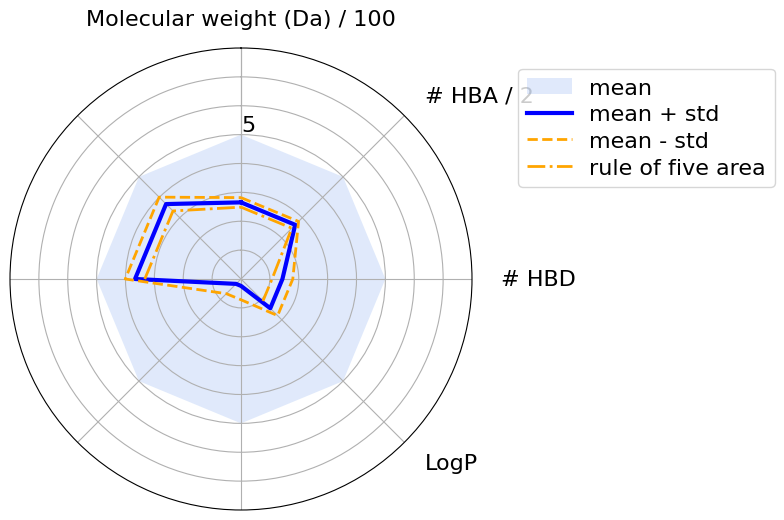

In [159]:
plot_radar(
    molecules_ro5_fulfilled_stats,
    thresholds,
    scaled_threshold,
    properties_labels,
    y_max,
)


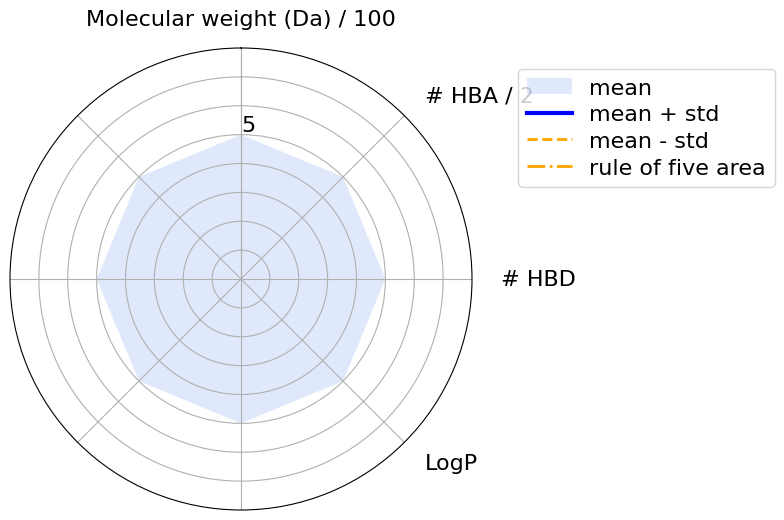

In [160]:
plot_radar(
    molecules_ro5_violated_stats,
    thresholds,
    scaled_threshold,
    properties_labels,
    y_max,
)

